# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from datetime import date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# **Loading the Dataset**  

In [2]:
gas = pd.read_csv('Nat_Gas.csv')
#gas = pd.DataFrame(gas)

dateFormat = '%m/%d/%y'
gas['Dates'] = pd.to_datetime(gas['Dates'], format=dateFormat)
gas = gas.set_index('Dates')
gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


# **Data Visualization**

<ipython-input-35-b2645f2d9e89>:7: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(dates, prices, '-')


<Figure size 1000x500 with 0 Axes>

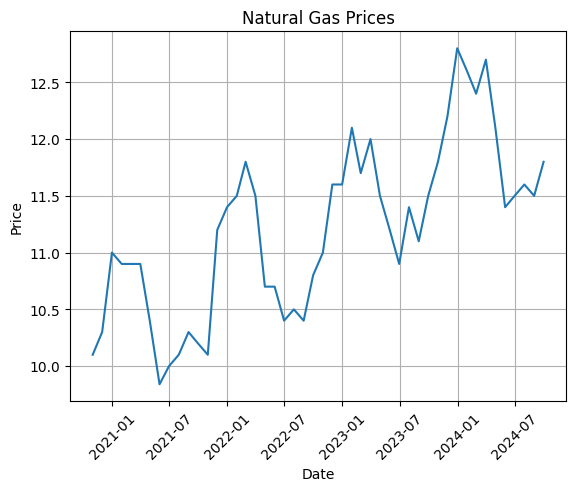

In [35]:
prices = gas['Prices'].values
dates = gas.index.values

# plot prices against dates
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
plt.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()


*All the highest points are from JAN/ FEB/ DEC but the lowest points are from MAY/ JUNE/ JULY.*  



# Method 1: Time Series
 *From the above graph, it is easily to see the seasonality of the time seies* *data with an increasing trend, thus the following analysis and prediction will aim at the seasonality with increasing trend.*

**Decomposition**

*Using STL Decdomposition because it can handle both Additive and Multiplicative seasonality*

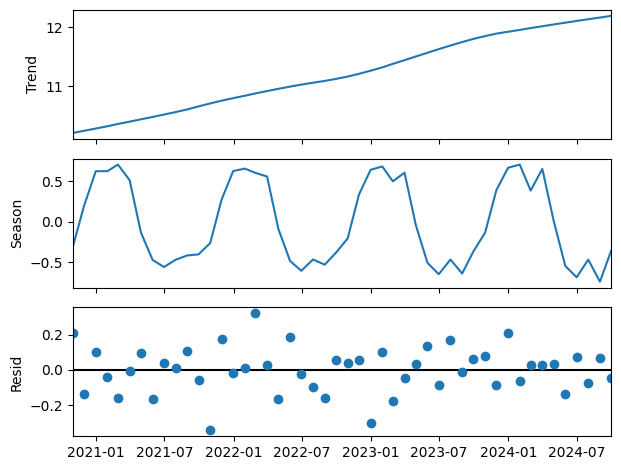

In [6]:
# Decompose using stl
stl = STL(gas["Prices"],seasonal=13)
# The STL implementation in statsmodels requires the seasonal parameter to be an odd integer greater than or equal to 3.
# This is a specific requirement for the LOESS-based decomposition method.
# In most cases, for monthly data, we'd expect a seasonality of 12.
# However, since STL requires it to be odd, thus seasonal = 13

result = stl.fit()

fig = result.plot(observed=False, resid=True)
plt.show()

In [7]:
gas.index.freq = 'ME'

*The plots shows the non-stationarity and seasonality of the data. To futher analysis and verify this observation, I would like to conduct the stationary test.*

In [8]:
#Stationary test
result_stationary = adfuller(gas.index.to_series())
print('ADF Statistic:', result_stationary[0])
print('p-value:', result_stationary[1])
print('Critical Values:', result_stationary[4])

ADF Statistic: 0.661675800129894
p-value: 0.9890411772696728
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}


*The stationary test gives the following results:*

*the ADF statistic is higher than every critical values calculated, confirms the* *non-stationarity of the data.*
*p-value is higher than 0.05, thus fail to reject the null hypothesis.*
*Both indicates the time series is non-stationary.*

**Make the data stationary**

*as the data is non-stationary as well as seasonal, the trend and the seasonality need to be removed.*

In [10]:
# Differencing to remove trend and seasonality
diff_series = gas.iloc[:, 0].diff().dropna()
seasonal_diff_series = diff_series.diff(7).dropna()

In [11]:
# ADF test on differenced series
result_stationary_diff = adfuller(seasonal_diff_series)

# ADF test results
print('ADF Statistic (differenced):', result_stationary_diff[0])
print('p-value (differenced):', result_stationary_diff[1])
print('Critical Values (differenced):', result_stationary_diff[4])

ADF Statistic (differenced): -5.236781574608509
p-value (differenced): 7.392576450511088e-06
Critical Values (differenced): {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}


*The ADF test and the p-value indicate the rejection of the null hypothesis. The data is stationary now.*

*Process to fit the ARIMA model.*

**ARIMA Model**

*use ACF and PACF to determine parameters p, d, q in the ARIMA model*

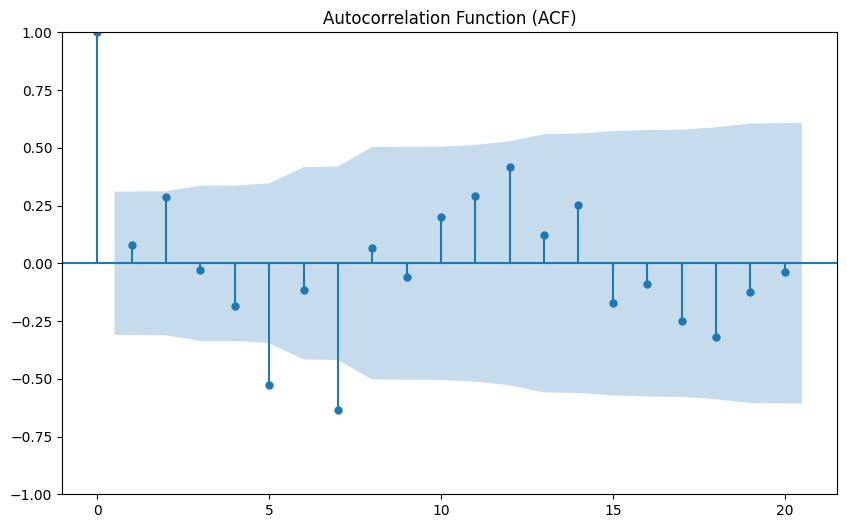

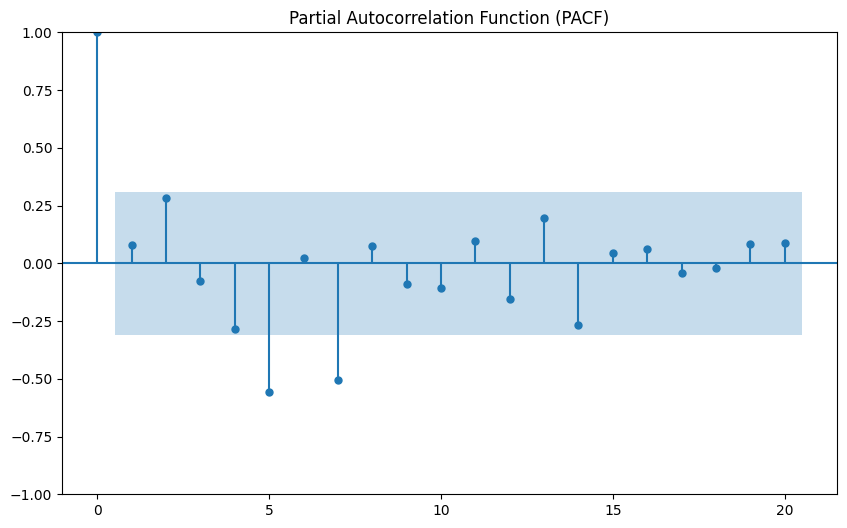

In [13]:
%matplotlib inline

plt.clf()
plt.close()

#plot_acf(result.resid.dropna(), lags=20)

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(seasonal_diff_series, lags=20, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF for completeness
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(seasonal_diff_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

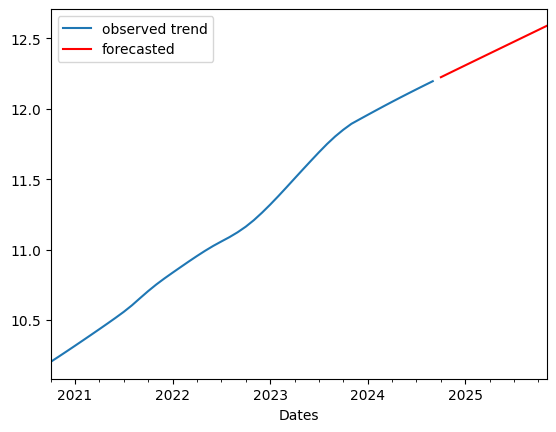

In [14]:
trend = ARIMA(result.trend.dropna(), order=(1,2,1))
trendFit = trend.fit()
forecastPeriods = 14
trendForecast = trendFit.forecast(steps = forecastPeriods)
result.trend.plot(label = 'observed trend')
trendForecast.plot(label = 'forecasted', color = 'red')

plt.legend()
plt.show()

In [15]:
# Model and forecast the residuals
resModel = ARIMA(result.resid.dropna(), order=(1,1,1))
resFit = resModel.fit()
resForecast = resFit.forecast(steps = forecastPeriods)

In [16]:
forecast_index = pd.date_range(start=gas.index[-1] + pd.Timedelta(days=30), periods=forecastPeriods, freq='ME' )

trendForecast.index = forecast_index
resForecast.index = forecast_index
seasonalForecast = result.seasonal.tail(forecastPeriods)
seasonalForecast.index = forecast_index

In [17]:
# combine the forecasted trend, known seasonality and forecasted residuals
forecastTol = trendForecast + seasonalForecast + resForecast

In [18]:
{
    'trendForecast': trendForecast.values,
    'seasonality': result.seasonal.tail(forecastPeriods).values,
    'resForecast': resForecast.values,
    'final': forecastTol.values
}

{'trendForecast': array([12.22458805, 12.25283562, 12.28099151, 12.30908399, 12.33713261,
        12.3651509 , 12.39314821, 12.42113101, 12.44910377, 12.47706959,
        12.5050306 , 12.53298829, 12.56094369, 12.5888975 ]),
 'seasonality': array([-0.63552585, -0.36331372, -0.13295403,  0.39039564,  0.66530816,
         0.70422968,  0.38503784,  0.65104295,  0.0142226 , -0.54231807,
        -0.68236394, -0.4649035 , -0.73629006, -0.35155912]),
 'resForecast': array([ 1.54896871e-02, -4.54746657e-03,  2.12857975e-03, -9.57678403e-05,
         6.45347780e-04,  3.98420382e-04,  4.80692484e-04,  4.53280788e-04,
         4.62413909e-04,  4.59370905e-04,  4.60384784e-04,  4.60046976e-04,
         4.60159528e-04,  4.60122028e-04]),
 'final': array([11.60455189, 11.88497443, 12.15016605, 12.69938387, 13.00308612,
        13.069779  , 12.77866675, 13.07262724, 12.46378878, 11.93521089,
        11.82312705, 12.06854484, 11.82511379, 12.2377985 ])}

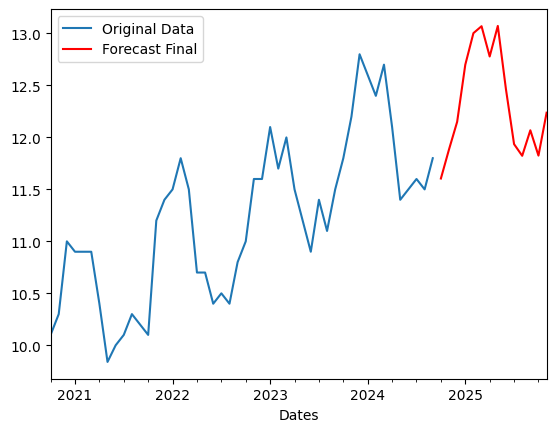

In [19]:
#plot
gas['Prices'].plot(label = 'Original Data')
forecastTol.plot(label = 'Forecast Final', color = 'red')

plt.legend()
plt.show()

In [20]:
forecastTol.index

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31', '2025-11-30'],
              dtype='datetime64[ns]', freq='ME')

In [21]:
def forecastedPrice(date_string):
    try:
        date_obj = pd.to_datetime(date_string)

        if date_obj in forecastTol.index:
            return forecastTol[date_obj]
        else:
            return f'{date_string} out of forecasted range'
    except Exception as e:
        return f'Error: {e}'

*To keep in mind the above function has yet no interpolation to predict prices for dates in between the dates given in dataset*.

In [22]:
test = '2024-10-31'
forecastedPrice(test)

11.604551891640568

In [23]:
test2 = '2025-01-31'
forecastedPrice(test2)

12.699383865710432

In [38]:
test3= '2024-10-15'
forecastedPrice(test3)

'2024-10-15 out of forecasted range'

# Method 2: Bilinear Regression


In [24]:
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.

# First we need the dates in terms of days from the start, to make it easier to interpolate later.
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_from_start = [(day - start_date ).days for day in months]

In [25]:
# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2},
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

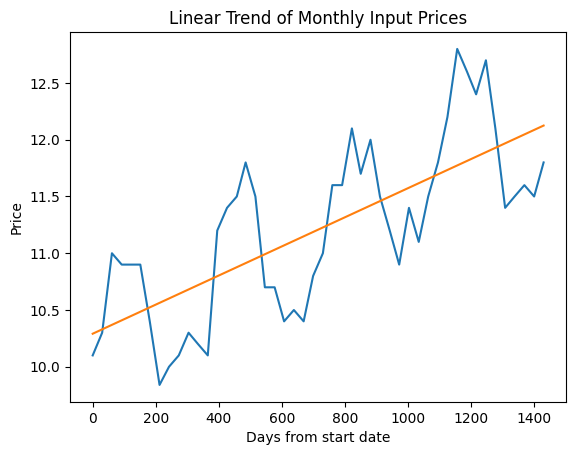

0.001282373598760221 10.29104112595228


In [26]:
# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

In [27]:
# From this plot we see the linear trend has been captured. Now to fit the intra-year variation.
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt),
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

In [28]:
# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

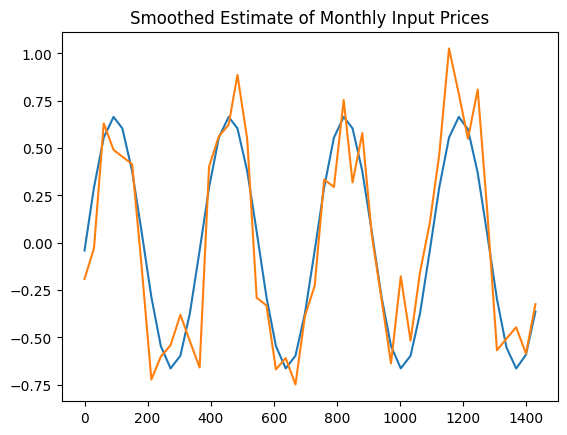

In [29]:
# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')

In [30]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

In [31]:
# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

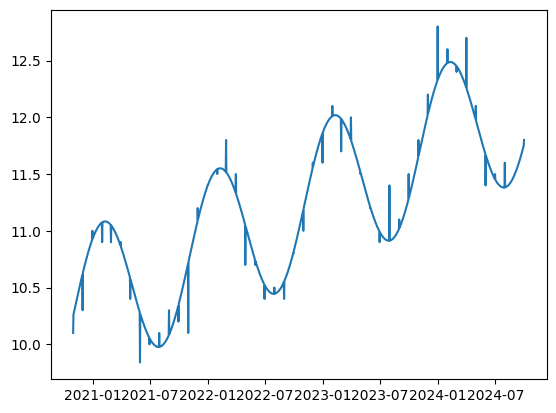

In [32]:
# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

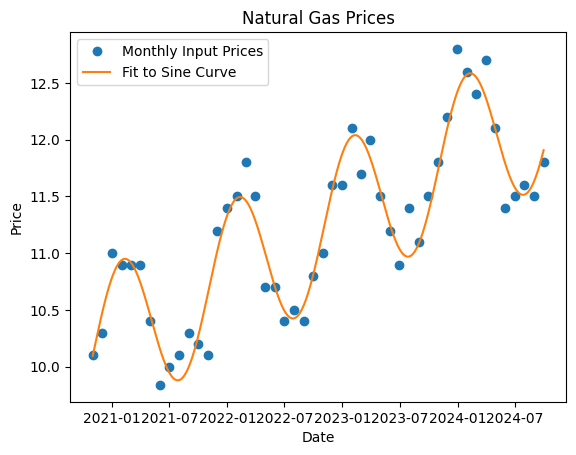

In [36]:
# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()